# Table Of Content

1. [introducion](#1)
2. [imports](#2)
3. [Data Loading And Description](#3)
4. [Univariant Visualization (spark)](#4)
5. [Bivariant Visualization (spark)](#5)
6. [Preprocessing (spark)](#6)
7. [Deeplearning Model](#7)
8. [Gradient Boosting Tree (spark)](#8)

<a id="1"></a>
# Introduction

LendingClub is a US peer-to-peer lending company, headquartered in San Francisco, California. It was the first peer-to-peer lender to register its offerings as securities with the Securities and Exchange Commission, and to offer loan trading on a secondary market. LendingClub is the world's largest peer-to-peer lending platform, Given historical data on loans given out with information on whether or not the borrower defaulted (charge-off), we can build a model that can predict if a borrower will pay back their loan. This way in the future when we get a new potential customer, we can assess if they are likely to pay back the loan.

Objectives of this notebook is: 
- To show step-by-step how to visualize the dataset.
- Data cleaning and preprocessing.
- Assess whether or not a new customer is likely to pay back the loan.

<a id="2"></a>
# Imports

In [1]:
# Spark Session, Pipeline, Functions, and Metrics
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext, SparkSession
from pyspark.ml.feature import OneHotEncoder, StringIndexer, MinMaxScaler, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import rand, col, isnan, when, count, create_map, lit
from pyspark.mllib.stat import Statistics

# Keras / Deep Learning
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import Adam

# Plotting
from pyspark_dist_explore import hist
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

# Extra imports
import numpy as np
import pandas as pd
from itertools import chain

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
# Spark Session
conf = SparkConf().setAppName("Predict Loan Payback").setMaster("local[6]") # 6 cores
sc = SparkContext(conf=conf)
sql_context = SQLContext(sc)

In [4]:
# sc.stop()
sc

<SparkContext master=local[6] appName=Predict Loan Payback>

<a id="3"></a>
# Data Loading And Description

In [5]:
df = pd.read_excel ("./data/LCDataDictionary.xlsx")
df.rename(columns={'LoanStatNew': 'Columns'}, inplace=True)
df = df[["Columns", "Description"]]
df = df.iloc[:-2 , :] # last two columns Nan
with pd.option_context('display.max_rows', None, 'display.max_colwidth', None):
    display(df)

,Columns,Description
0,acc_now_delinq,The number of accounts on which the borrower is now delinquent.
1,acc_open_past_24mths,Number of trades opened in past 24 months.
2,addr_state,The state provided by the borrower in the loan application
3,all_util,Balance to credit limit on all trades
4,annual_inc,The self-reported annual income provided by the borrower during registration.
5,annual_inc_joint,The combined self-reported annual income provided by the co-borrowers during registration
6,application_type,Indicates whether the loan is an individual application or a joint application with two co-borrowers
7,avg_cur_bal,Average current balance of all accounts
8,bc_open_to_buy,Total open to buy on revolving bankcards.
9,bc_util,Ratio of total current balance to high credit/credit limit for all bankcard accounts.


In [5]:
# Load Data to Spark Dataframe
df = sql_context.read.csv("./data/accepted_2007_to_2018Q4.csv", header=True, inferSchema=True)

In [5]:
# View Schema
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- member_id: string (nullable = true)
 |-- loan_amnt: double (nullable = true)
 |-- funded_amnt: double (nullable = true)
 |-- funded_amnt_inv: double (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_title: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: string (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- issue_d: string (nullable = true)
 |-- loan_status: string (nullable = true)
 |-- pymnt_plan: string (nullable = true)
 |-- url: string (nullable = true)
 |-- desc: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- title: string (nullable = true)
 |-- zip_code: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- dti: string 

In [6]:
# Fix columns type that should be numbers
cols = ['annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high', 
        'last_fico_range_low', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal',
        'revol_util', 'total_acc', 'total_rec_int', 'total_rec_late_fee', 'recoveries',
        'last_pymnt_amnt', 'last_fico_range_high', 'collections_12_mths_ex_med', 'acc_now_delinq',
        'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_prncp', 'collection_recovery_fee',
        'out_prncp', 'out_prncp_inv', 'policy_code']
for col_name in cols:
    df = df.withColumn(col_name, col(col_name).cast('double'))

In [6]:
df.limit(5).toPandas()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,None,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,None,None,Cash,N,None,None,None,None,None,None
1,68355089,None,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,None,None,Cash,N,None,None,None,None,None,None
2,68341763,None,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,None,None,Cash,N,None,None,None,None,None,None
3,66310712,None,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,None,None,Cash,N,None,None,None,None,None,None
4,68476807,None,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,None,None,Cash,N,None,None,None,None,None,None


<a id="4"></a>
# Univariant Visualization

In [7]:
def get_cat_numeric_cols(df):
    cat = []
    numeric = []
    for x, y in df.dtypes:
        if y == "string": 
            cat.append(x)
        else:
            numeric.append(x)
    return cat, numeric

## Loan Status Distribution

In [6]:
df.groupBy("loan_status").count().toPandas()

,loan_status,count
0,Fully Paid,1076751
1,Default,40
2,None,33
3,In Grace Period,8436
4,Does not meet the credit policy. Status:Fully ...,1988
5,Charged Off,268558
6,Oct-2015,1
7,Late (31-120 days),21467
8,Current,878317
9,Does not meet the credit policy. Status:Charge...,761


In [7]:
to_plot = df.groupBy("loan_status").count()
to_plot.show()

+--------------------+-------+
|         loan_status|  count|
+--------------------+-------+
|          Fully Paid|1076751|
|             Default|     40|
|                null|     33|
|     In Grace Period|   8436|
|Does not meet the...|   1988|
|         Charged Off| 268558|
|            Oct-2015|      1|
|  Late (31-120 days)|  21467|
|             Current| 878317|
|Does not meet the...|    761|
|   Late (16-30 days)|   4349|
+--------------------+-------+



In [8]:
to_plot = to_plot.toPandas()

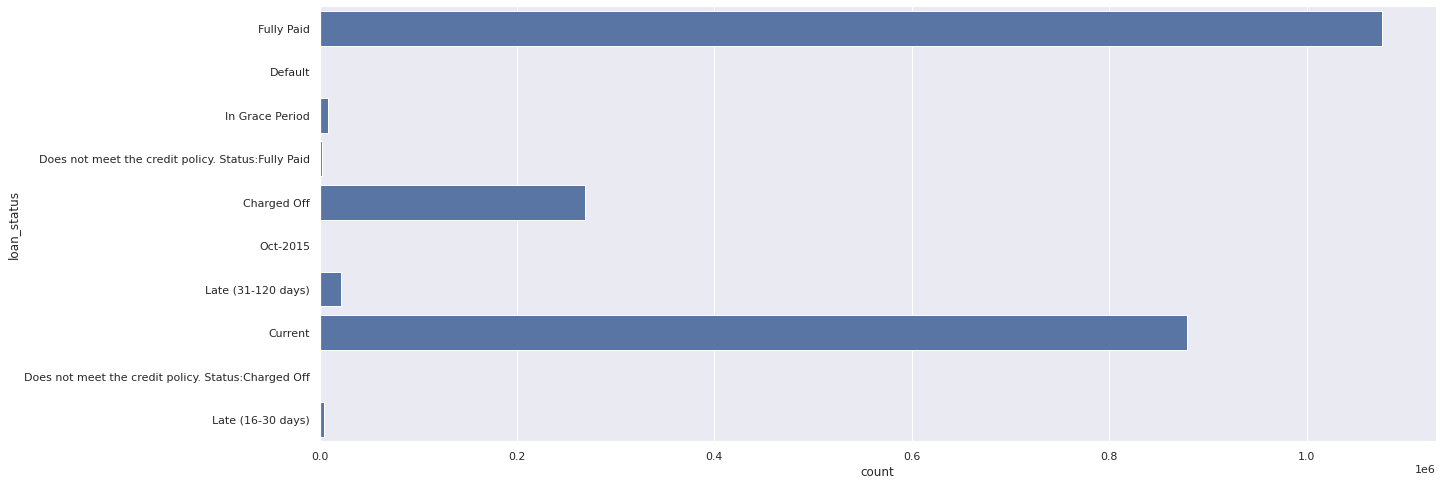

In [12]:
plt.figure(figsize=(20,8))
sns.barplot(y="loan_status", x="count", data=to_plot, color='b');

In [8]:
# filter the loan status to be only fully paid and charged off
df = df.filter('loan_status in ("Fully Paid", "Charged Off")')

In [9]:
to_plot = df.groupBy("loan_status").count()

In [14]:
to_plot.show()

+-----------+-------+
|loan_status|  count|
+-----------+-------+
| Fully Paid|1076751|
|Charged Off| 268558|
+-----------+-------+



In [15]:
to_plot = to_plot.toPandas()

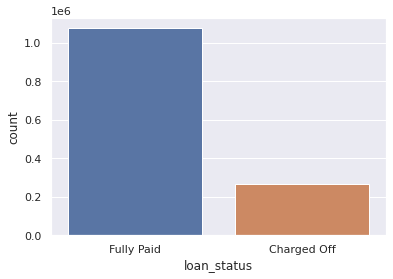

In [16]:
sns.barplot(x="loan_status", y="count", data=to_plot);

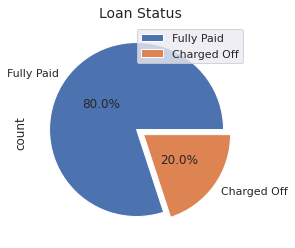

In [17]:
labels = to_plot["loan_status"].values
to_plot.plot.pie(x="loan_status", y="count", autopct="%.1f%%", explode=[0.05]*len(labels), labels=labels, pctdistance=0.5)
plt.title("Loan Status", fontsize=14);

In [9]:
def spark_df_shape(df):
    return df.count(), len(df.columns)

In [10]:
print(spark_df_shape(df))

(1345309, 151)


## Nulls Distribtion
- Get columns which has the most number of null values and sort them

In [11]:
to_drop = df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas()

In [12]:
to_drop.sum().sort_values(ascending=False).head(50)

member_id                                     1345309
next_pymnt_d                                  1345086
orig_projected_additional_accrued_interest    1341548
hardship_last_payment_amount                  1339554
hardship_payoff_balance_amount                1339554
hardship_dpd                                  1339550
hardship_loan_status                          1339548
hardship_start_date                           1339547
hardship_end_date                             1339546
hardship_length                               1339545
payment_plan_start_date                       1339543
hardship_amount                               1339540
deferral_term                                 1339532
hardship_status                               1339521
hardship_reason                               1339513
hardship_type                                 1339504
sec_app_mths_since_last_major_derog           1338662
sec_app_revol_util                            1327004
sec_app_num_rev_accts       

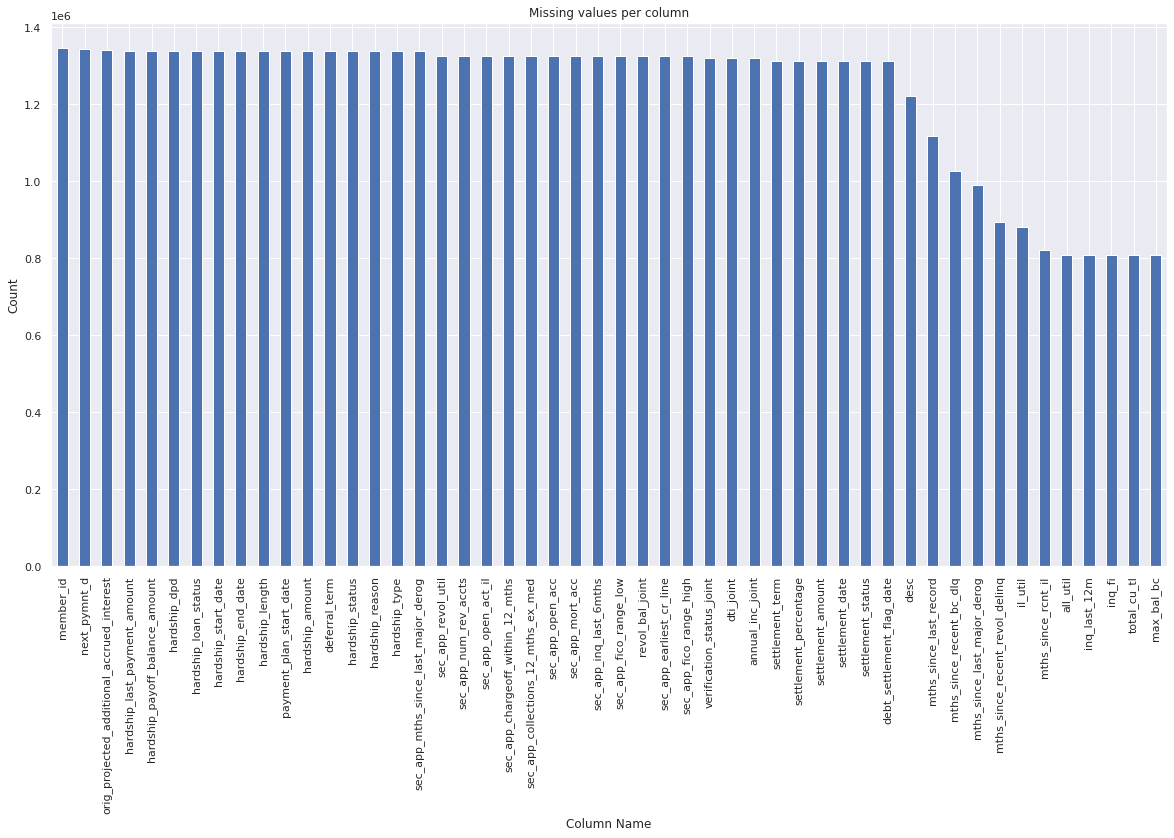

In [13]:
plt.figure(figsize=(20,10))
to_drop.sum().sort_values(ascending=False).head(50).plot.bar(title='Missing values per column')
plt.xlabel("Column Name")
plt.ylabel("Count");

The first most 50 columns with highest numbers of nulls values (Almost all the values are null as number of rows are 1345309 initially)

In [14]:
to_drop.sum().sort_values(ascending=False)[50:].head(50)

open_rv_12m                   807699
open_rv_24m                   807693
total_bal_il                  807685
open_il_24m                   807678
open_il_12m                   807673
open_act_il                   807645
open_acc_6m                   807631
mths_since_last_delinq        678599
mths_since_recent_inq         174049
num_tl_120dpd_2m              117400
mo_sin_old_il_acct            105485
emp_title                      85785
emp_length                     78511
pct_tl_nvr_dlq                 67681
avg_cur_bal                    67546
num_tl_30dpd                   67527
num_rev_accts                  67526
num_bc_tl                      67526
num_actv_rev_tl                67525
num_tl_op_past_12m             67525
num_tl_90g_dpd_24m             67525
num_rev_tl_bal_gt_0            67525
total_rev_hi_lim               67522
num_il_tl                      67521
num_op_rev_tl                  67520
num_actv_bc_tl                 67518
num_accts_ever_120_pd          67516
t

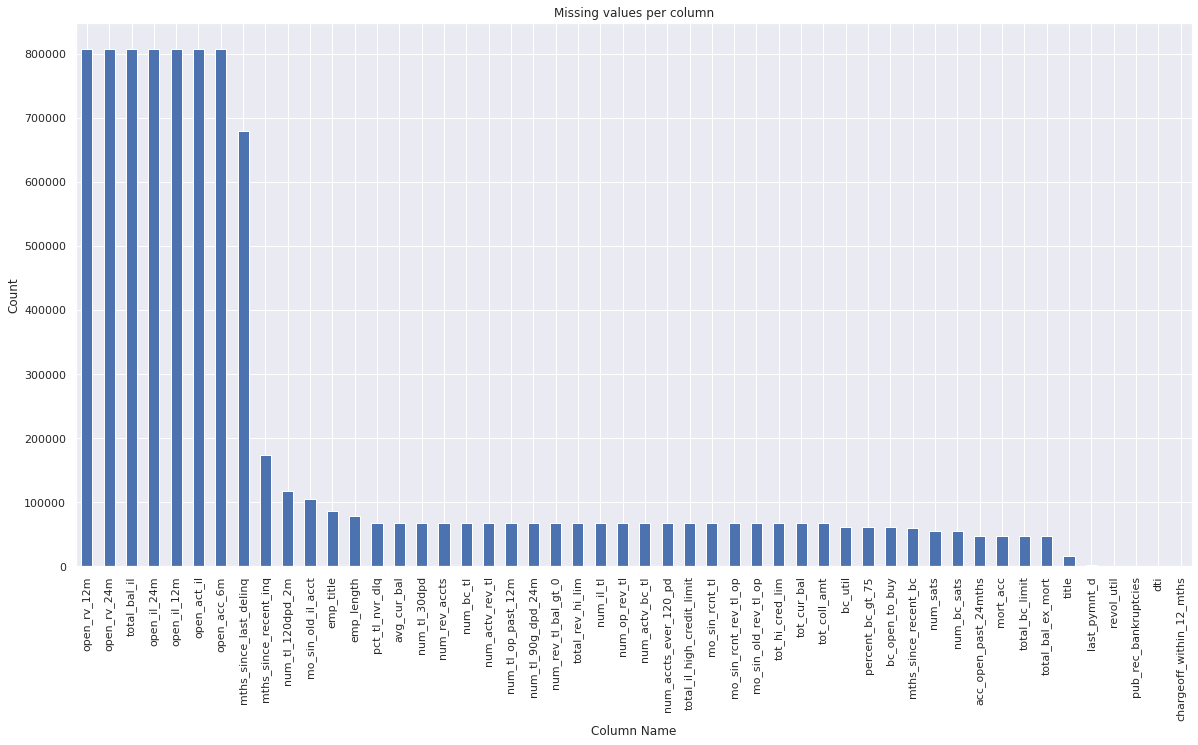

In [15]:
plt.figure(figsize=(20,10))
to_drop.sum().sort_values(ascending=False)[50:].head(50).plot.bar(title='Missing values per column')
plt.xlabel("Column Name")
plt.ylabel("Count");

> The first 95 columns has lots of nulls so I will drop them

In [16]:
to_drop = list(to_drop.sum().sort_values(ascending=False).head(95).index)

In [17]:
print(to_drop)

['member_id', 'next_pymnt_d', 'orig_projected_additional_accrued_interest', 'hardship_last_payment_amount', 'hardship_payoff_balance_amount', 'hardship_dpd', 'hardship_loan_status', 'hardship_start_date', 'hardship_end_date', 'hardship_length', 'payment_plan_start_date', 'hardship_amount', 'deferral_term', 'hardship_status', 'hardship_reason', 'hardship_type', 'sec_app_mths_since_last_major_derog', 'sec_app_revol_util', 'sec_app_num_rev_accts', 'sec_app_open_act_il', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_open_acc', 'sec_app_mort_acc', 'sec_app_inq_last_6mths', 'sec_app_fico_range_low', 'revol_bal_joint', 'sec_app_earliest_cr_line', 'sec_app_fico_range_high', 'verification_status_joint', 'dti_joint', 'annual_inc_joint', 'settlement_term', 'settlement_percentage', 'settlement_amount', 'settlement_date', 'settlement_status', 'debt_settlement_flag_date', 'desc', 'mths_since_last_record', 'mths_since_recent_bc_dlq', 'mths_since_last_major_derog',

In [18]:
df = df.drop(*to_drop)

In [19]:
print(spark_df_shape(df))

(1345309, 56)


> Columns Dropped Successfully, Now for the rest of the columns that have missing values we can just drop the rows

In [20]:
df = df.na.drop()

In [21]:
print(spark_df_shape(df))

(1340812, 56)


> Rows Dropped Successfully

## Loan Amount Distribution

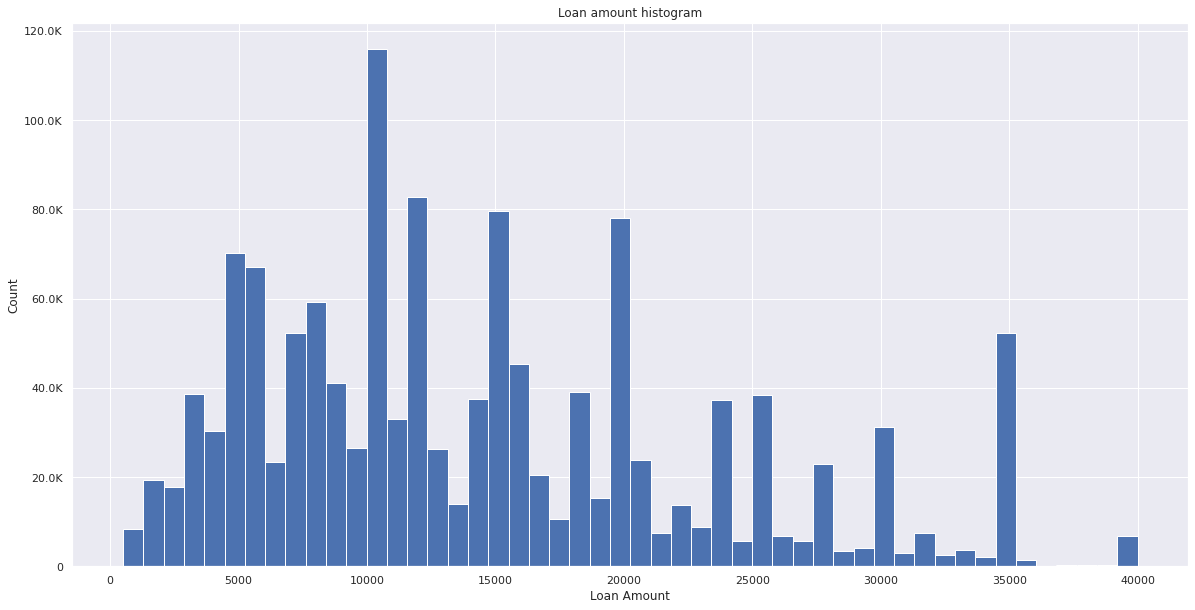

In [66]:
to_plot = df.select("loan_amnt")
fig, ax = plt.subplots()
hist(ax, to_plot, bins=50)
fig.set_size_inches(20, 10)
plt.title("Loan amount histogram")
plt.xlabel("Loan Amount")
plt.ylabel("Count");

In [28]:
categorical_cols, numeric_cols = get_cat_numeric_cols(df)
print(categorical_cols)
print(len(categorical_cols))

['id', 'term', 'grade', 'sub_grade', 'home_ownership', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'purpose', 'zip_code', 'addr_state', 'earliest_cr_line', 'initial_list_status', 'last_pymnt_d', 'last_credit_pull_d', 'application_type', 'hardship_flag', 'disbursement_method', 'debt_settlement_flag']
21


In [16]:
cols = list(set(categorical_cols)-set(["id", "zip_code", "url", "issue_d", "last_pymnt_d", "last_credit_pull_d"]))
features_dict = {}
for f in cols:
    features_dict[f] = []
for val in df.select(*cols).collect():
    for f, l in features_dict.items():
        l.append(val[f])

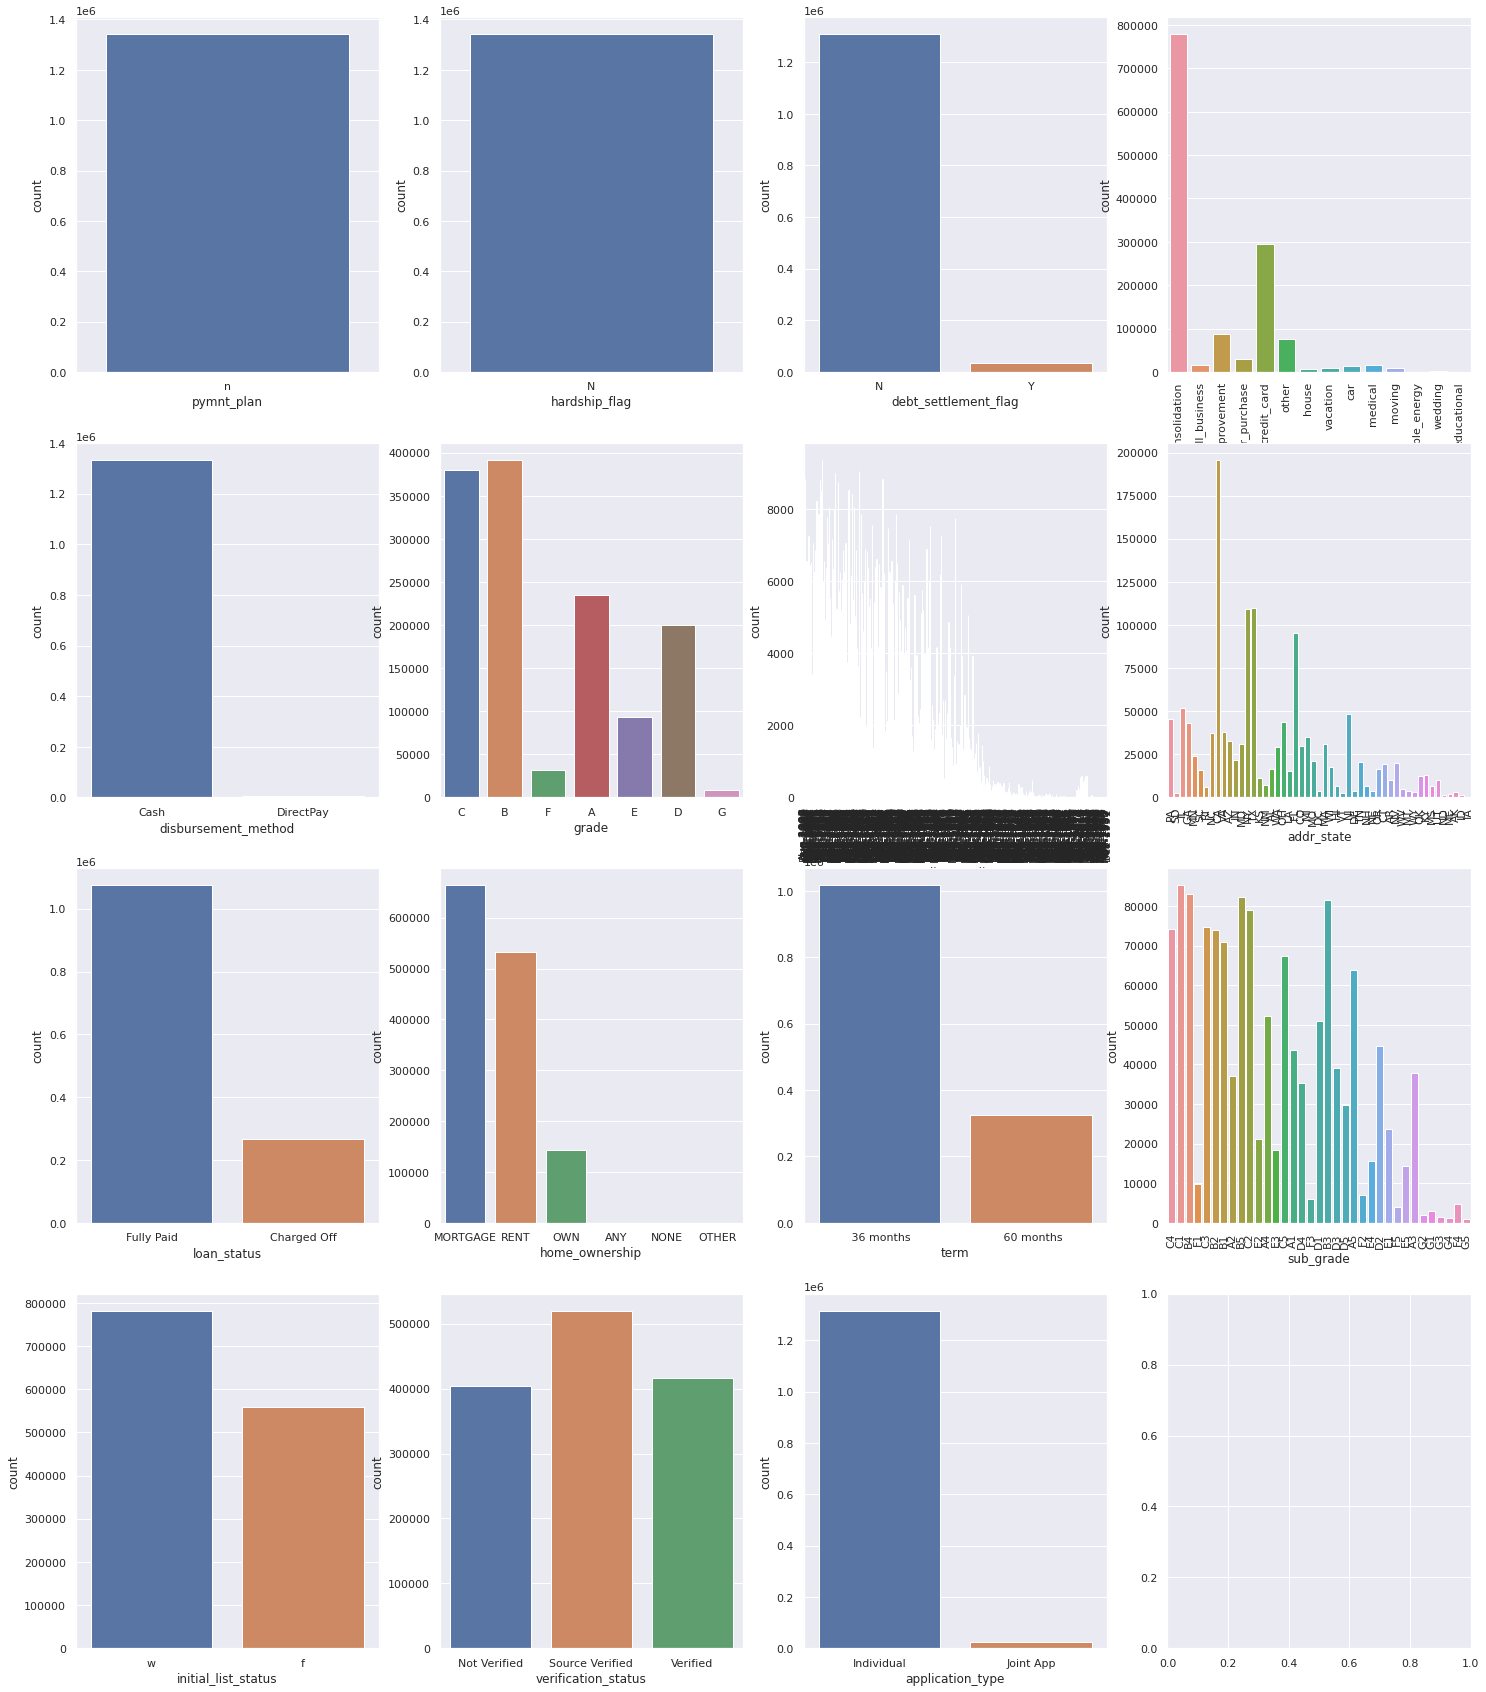

In [27]:
fig, axes = plt.subplots(4, 4, figsize=(25,30))
for i, f in enumerate(cols):
    sns.countplot(ax=axes[i//4, i%4], x=features_dict[f])
    ax = axes[i//4, i%4]
    ax.set_xlabel(f)
    if (len(ax.get_xticklabels()) > 10):
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

In [30]:
features_dict = None

In [31]:
cols = numeric_cols
features_dict = {}
for f in cols:
    features_dict[f] = []
for val in df.select(*cols).collect():
    for f, l in features_dict.items():
        l.append(val[f])

In [32]:
len(cols)

35

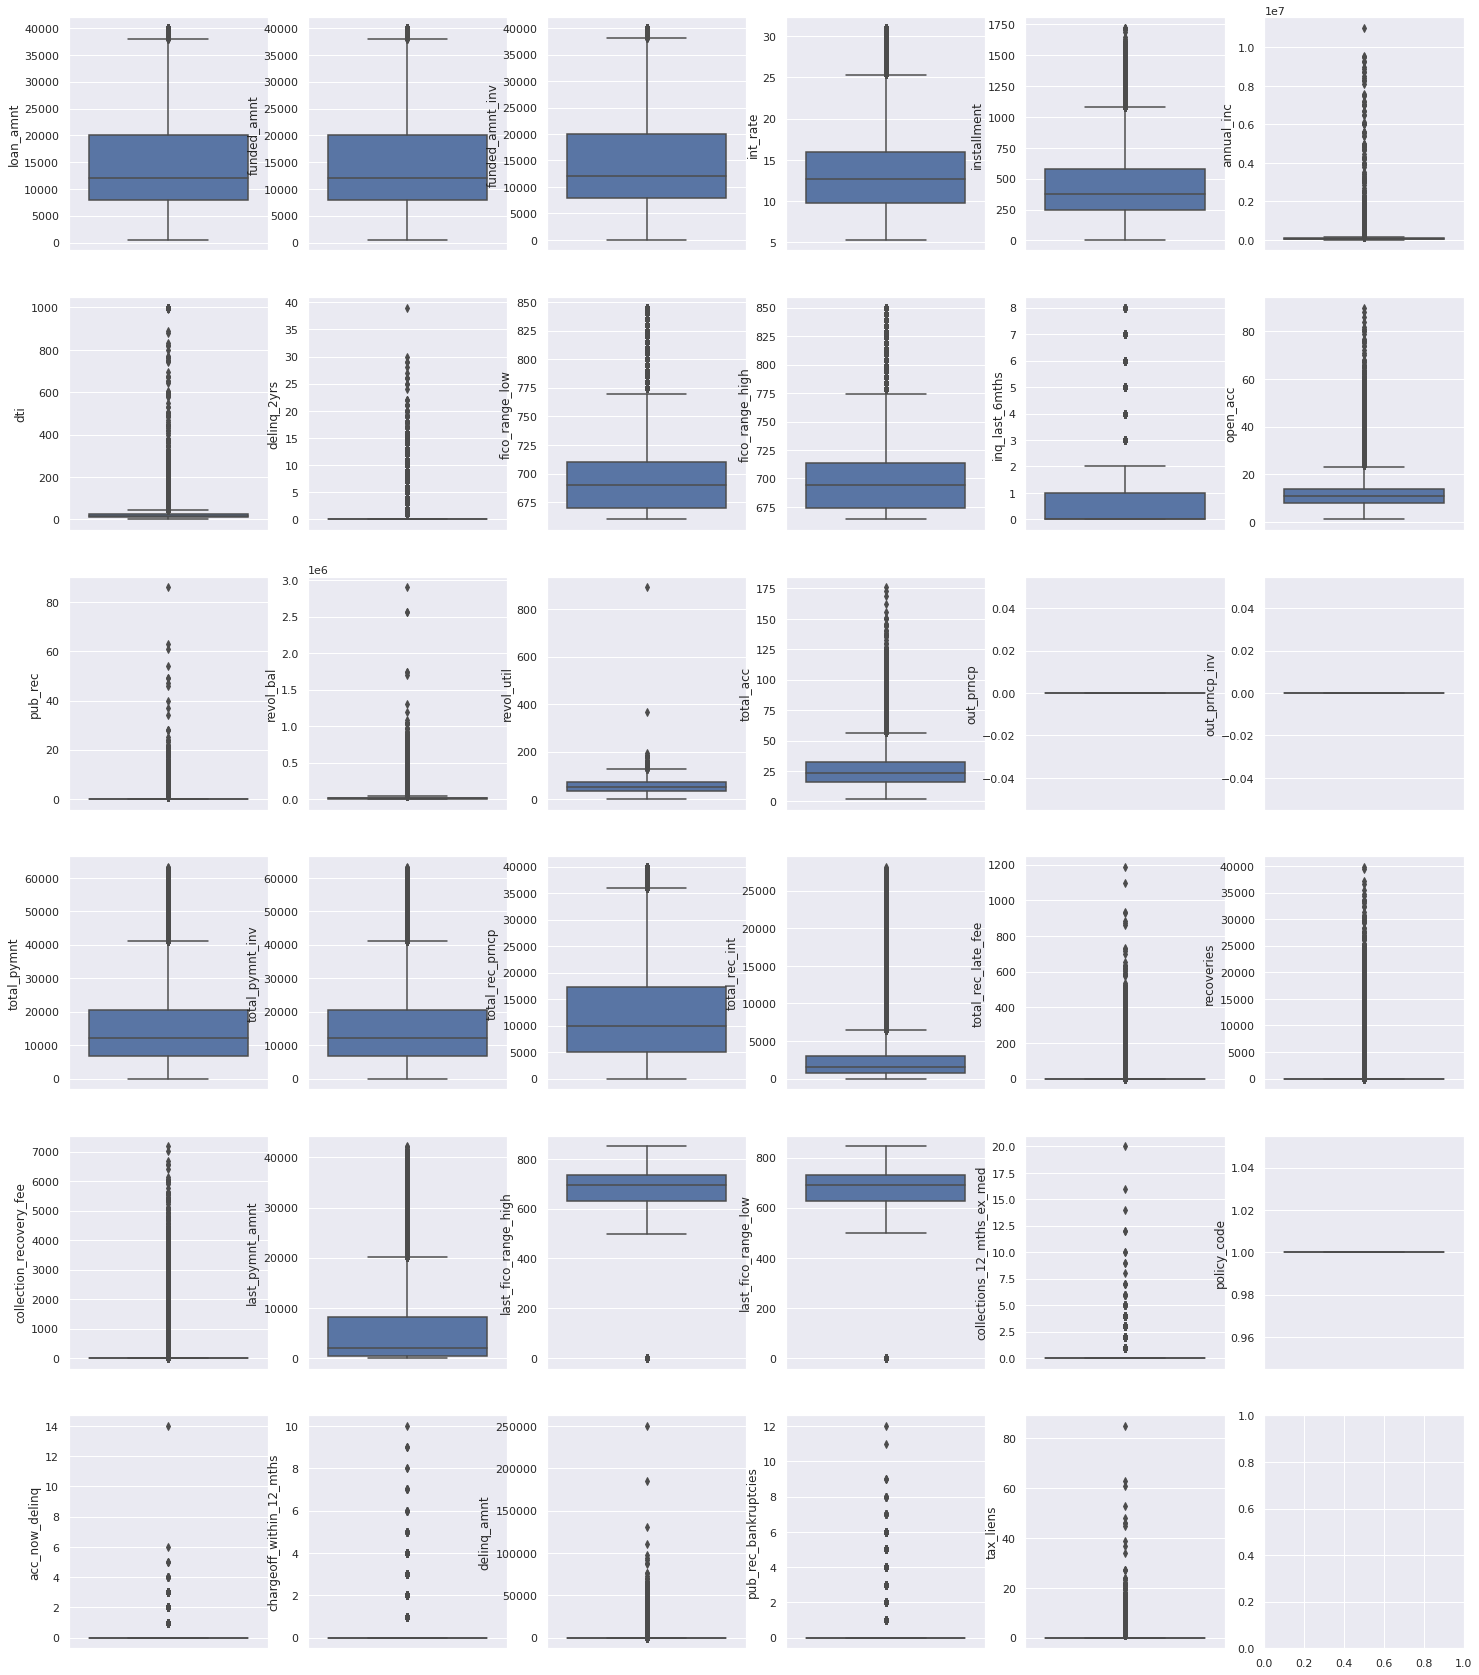

In [35]:
fig, axes = plt.subplots(6, 6, figsize=(25,30))
for i, f in enumerate(cols):
    ax = axes[i//6, i%6]
    ax.set_ylabel(f)
    sns.boxplot(ax=ax, y=features_dict[f]);

In [37]:
# Drop constant columns
df = df.drop("id", "pymnt_plan", "hardship_flag")

<a id="5"></a>
# Bivariant Visualization

In [34]:
# result can be used with seaborn's heatmap
def compute_correlation_matrix(df, method="pearson"):
    # wrapper around
    df_rdd = df.rdd.map(lambda row: row[0:])
    corr_mat = Statistics.corr(df_rdd, method=method)
    corr_mat_df = pd.DataFrame(corr_mat,
                    columns=df.columns, 
                    index=df.columns)
    return corr_mat_df

In [36]:
corrcategorical, corrnumeric = get_cat_numeric_cols(df)

In [37]:
corrcategorical

['term',
 'grade',
 'sub_grade',
 'home_ownership',
 'verification_status',
 'issue_d',
 'loan_status',
 'url',
 'purpose',
 'zip_code',
 'addr_state',
 'earliest_cr_line',
 'initial_list_status',
 'last_pymnt_d',
 'last_credit_pull_d',
 'application_type',
 'disbursement_method',
 'debt_settlement_flag']

In [38]:
corrnumeric

['loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'int_rate',
 'installment',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_amnt',
 'last_fico_range_high',
 'last_fico_range_low',
 'collections_12_mths_ex_med',
 'policy_code',
 'acc_now_delinq',
 'chargeoff_within_12_mths',
 'delinq_amnt',
 'pub_rec_bankruptcies',
 'tax_liens']

In [39]:
corr_df = df.select(*corrnumeric)
corr_mat = compute_correlation_matrix(corr_df)

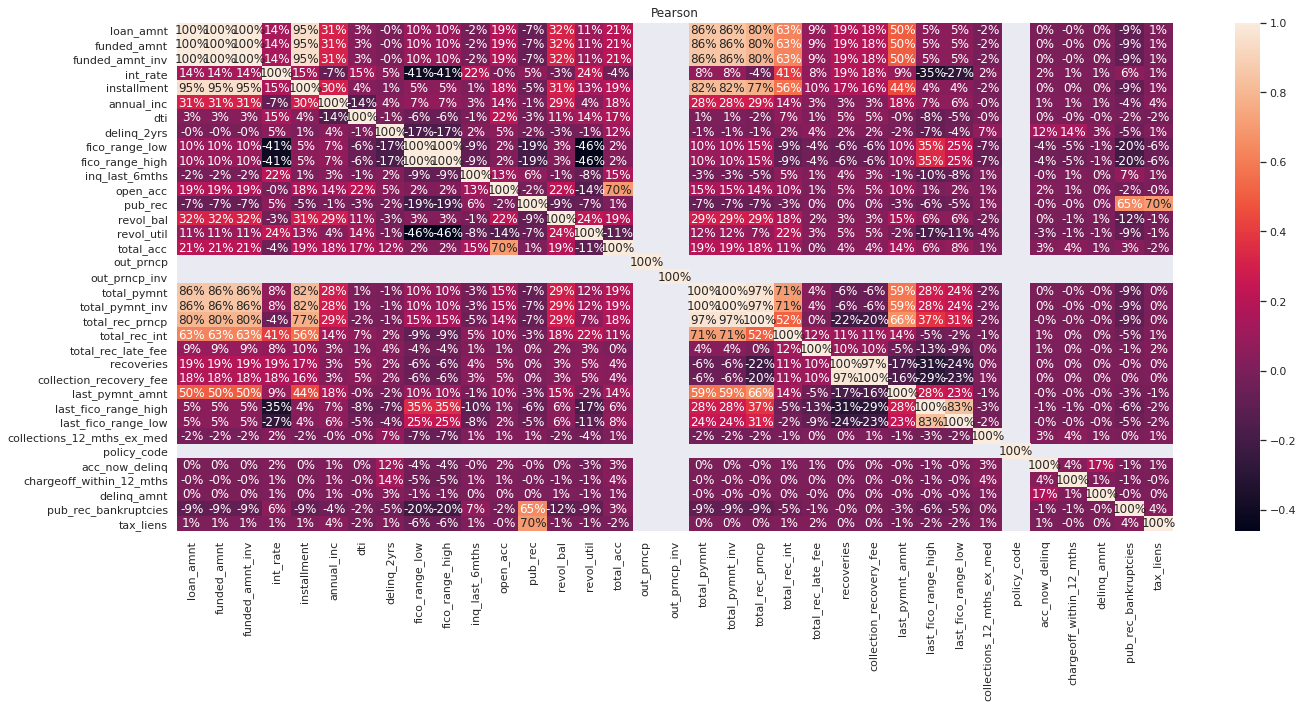

In [40]:
f, (ax1) = plt.subplots(1, figsize=(20, 10))
ax1.set_title("Pearson")
sns.heatmap(corr_mat, ax=ax1 , yticklabels=corrnumeric, xticklabels=corrnumeric, annot=True, fmt='.0%')
plt.yticks(rotation=0) 
plt.xticks(rotation=90)
ax1.figure.tight_layout()
plt.show();

In [41]:
# Drop 3 columns policy_code, out_prncp, out_prncp_inv
df = df.drop("policy_code", "out_prncp", "out_prncp_inv")

In [42]:
# check pairs of features above 0.8 in correlation
pairs = corr_mat.abs().unstack().sort_values(ascending=False)
corr_feature_pairs = pd.DataFrame(pairs).drop_duplicates().reset_index()
corr_feature_pairs.columns = ["feature1", "feature2", "corr"]
condition1 = corr_feature_pairs.feature1 != corr_feature_pairs.feature2
condition2 = corr_feature_pairs["corr"] > 0.8
corr_feature_pairs[condition1 & condition2]

,feature1,feature2,corr
1,fico_range_high,fico_range_low,1.000000
2,loan_amnt,funded_amnt,0.999567
3,total_pymnt_inv,total_pymnt,0.999548
4,funded_amnt_inv,funded_amnt,0.999447
5,funded_amnt_inv,loan_amnt,0.998929
6,collection_recovery_fee,recoveries,0.972815
7,total_rec_prncp,total_pymnt,0.967105
8,total_rec_prncp,total_pymnt_inv,0.966732
9,funded_amnt,installment,0.954036
10,installment,funded_amnt_inv,0.953455


It seems that the data have many duplicated information represented by multiple columns, so let's drop these duplicated columns

- fico_range_low = (fico_range_high)
- funded_amnt = funded_amnt_inv = installment = total_pymnt_inv = total_rec_prncp = total_pymnt = (loan_amnt)
- collection_recovery_fee = (recoveries)
- last_fico_range_low = (last_fico_range_high)

In [43]:
high_corr_list = [["fico_range_low", "fico_range_high"], 
                  ["funded_amnt", "funded_amnt_inv", "installment", "total_pymnt_inv", 
                   "total_rec_prncp", "total_pymnt", "loan_amnt"],
                  ["collection_recovery_fee", "recoveries"],
                  ["last_fico_range_low", "last_fico_range_high"]]
all_high_corr_list = sum(high_corr_list, [])

In [44]:
features_dict = {}
for f in all_high_corr_list:
    features_dict[f] = []

In [45]:
for val in df.select(*all_high_corr_list).collect():
    for f, l in features_dict.items():
        l.append(val[f])

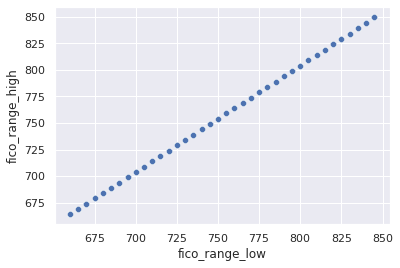

In [74]:
xfeature = high_corr_list[0][0]
yfeature = high_corr_list[0][1]
sns.scatterplot(x=features_dict[xfeature], y=features_dict[yfeature])
plt.xlabel(xfeature)
plt.ylabel(yfeature);

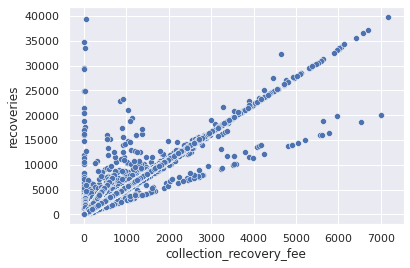

In [75]:
xfeature = high_corr_list[2][0]
yfeature = high_corr_list[2][1]
sns.scatterplot(x=features_dict[xfeature], y=features_dict[yfeature])
plt.xlabel(xfeature)
plt.ylabel(yfeature);

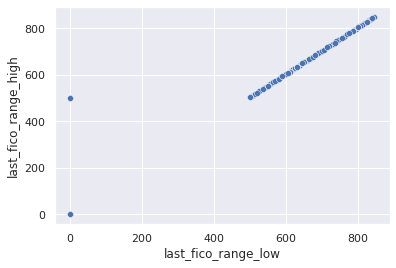

In [76]:
xfeature = high_corr_list[3][0]
yfeature = high_corr_list[3][1]
sns.scatterplot(x=features_dict[xfeature], y=features_dict[yfeature])
plt.xlabel(xfeature)
plt.ylabel(yfeature);

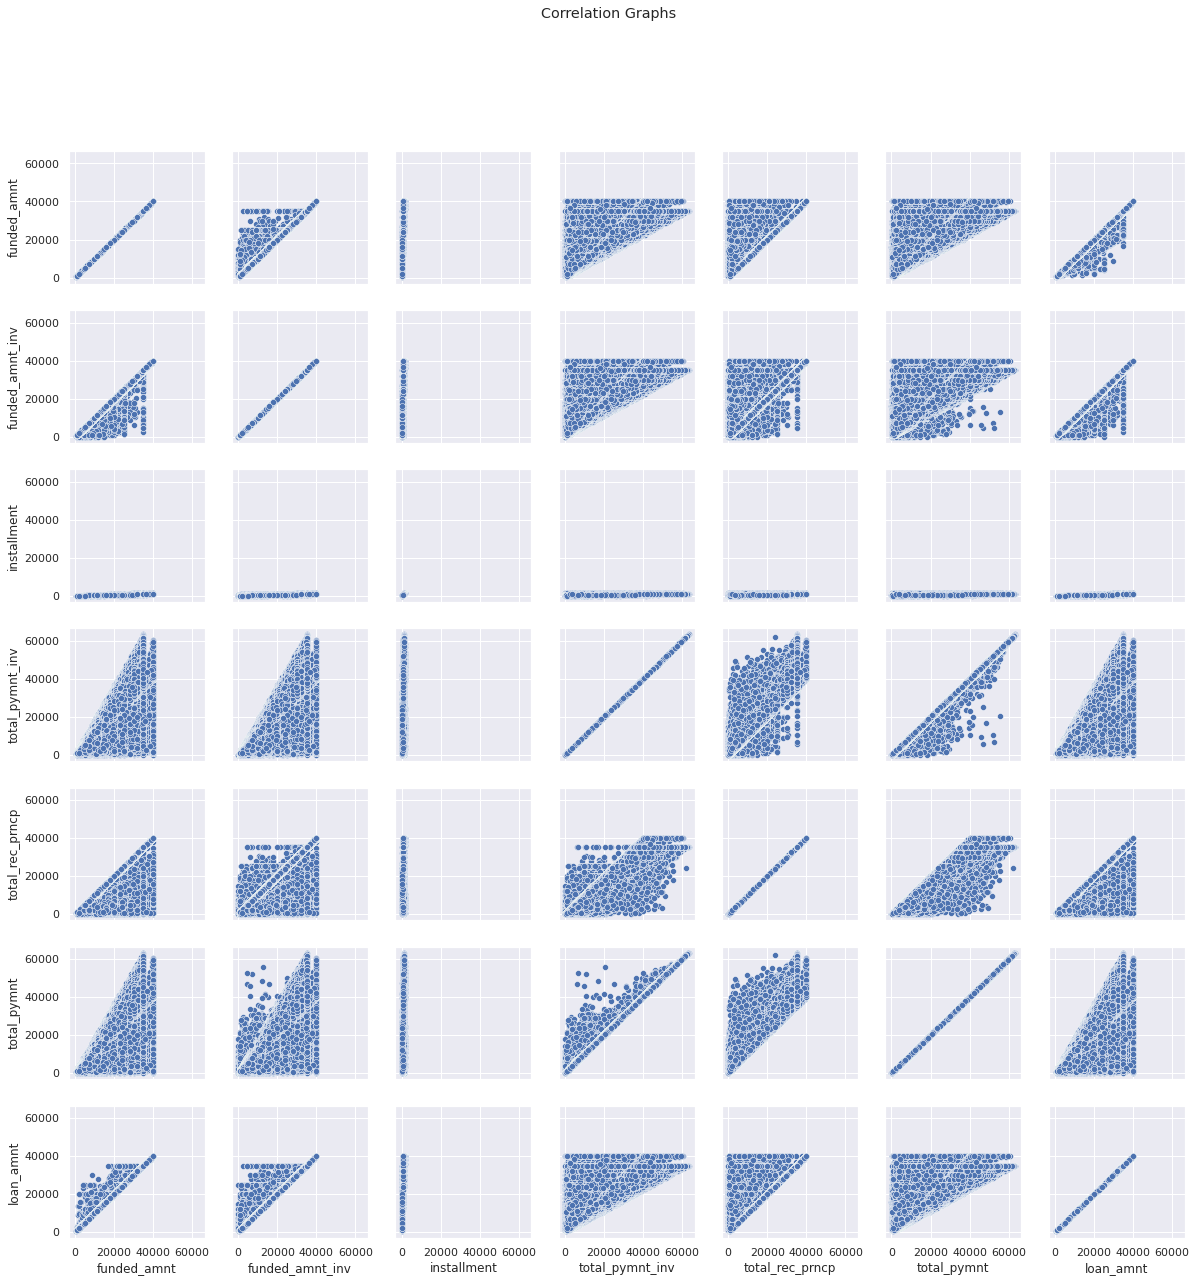

In [107]:
fig, axes = plt.subplots(len(high_corr_list[1]), len(high_corr_list[1]), sharex=True, sharey=True, figsize=(20,20))
fig.suptitle("Correlation Graphs")
for i, yfeature in enumerate(high_corr_list[1]):
    for j, xfeature in enumerate(high_corr_list[1]):
        sns.scatterplot(ax=axes[i, j], x=features_dict[xfeature], y=features_dict[yfeature])
for i in range(len(high_corr_list[1])):
    axes[-1, i].set_xlabel(high_corr_list[1][i])
    axes[i, 0].set_ylabel(high_corr_list[1][i]);

In [110]:
features_dict = None # empty this variable

Drop multiple information columns

In [22]:
to_drop = list(set(all_high_corr_list) - set([l[-1] for l in high_corr_list]))
print(to_drop)

['funded_amnt', 'last_fico_range_low', 'collection_recovery_fee', 'funded_amnt_inv', 'installment', 'total_pymnt_inv', 'total_rec_prncp', 'total_pymnt', 'fico_range_low']


In [23]:
df = df.drop(*to_drop)

In [24]:
print(spark_df_shape(df))

(1340812, 41)


<a id="6"></a>
# Preprocessing

### loan_status Column

In [27]:
mapping = {"Fully Paid": 1, "Charged Off": 0}

mapping_expr = create_map([lit(x) for x in chain(*mapping.items())])

df = df.withColumn("loan_is_paid", mapping_expr[col("loan_status")])

In [28]:
df.groupBy("loan_is_paid").count().show()

+------------+-------+
|loan_is_paid|  count|
+------------+-------+
|           1|1074961|
|           0| 265851|
+------------+-------+



In [32]:
# Drop it now
df = df.drop("loan_status")

In [33]:
corrcategorical, corrnumeric = get_cat_numeric_cols(df)

In [34]:
corrnumeric

['loan_amnt',
 'int_rate',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'fico_range_high',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'last_pymnt_amnt',
 'last_fico_range_high',
 'collections_12_mths_ex_med',
 'acc_now_delinq',
 'chargeoff_within_12_mths',
 'delinq_amnt',
 'pub_rec_bankruptcies',
 'tax_liens',
 'loan_is_paid']

In [37]:
corrcategorical

['term',
 'grade',
 'sub_grade',
 'home_ownership',
 'verification_status',
 'issue_d',
 'url',
 'purpose',
 'zip_code',
 'addr_state',
 'earliest_cr_line',
 'initial_list_status',
 'last_pymnt_d',
 'last_credit_pull_d',
 'application_type',
 'disbursement_method',
 'debt_settlement_flag']

In [35]:
corr_df = df.select(*corrnumeric)
corr_mat = compute_correlation_matrix(corr_df)

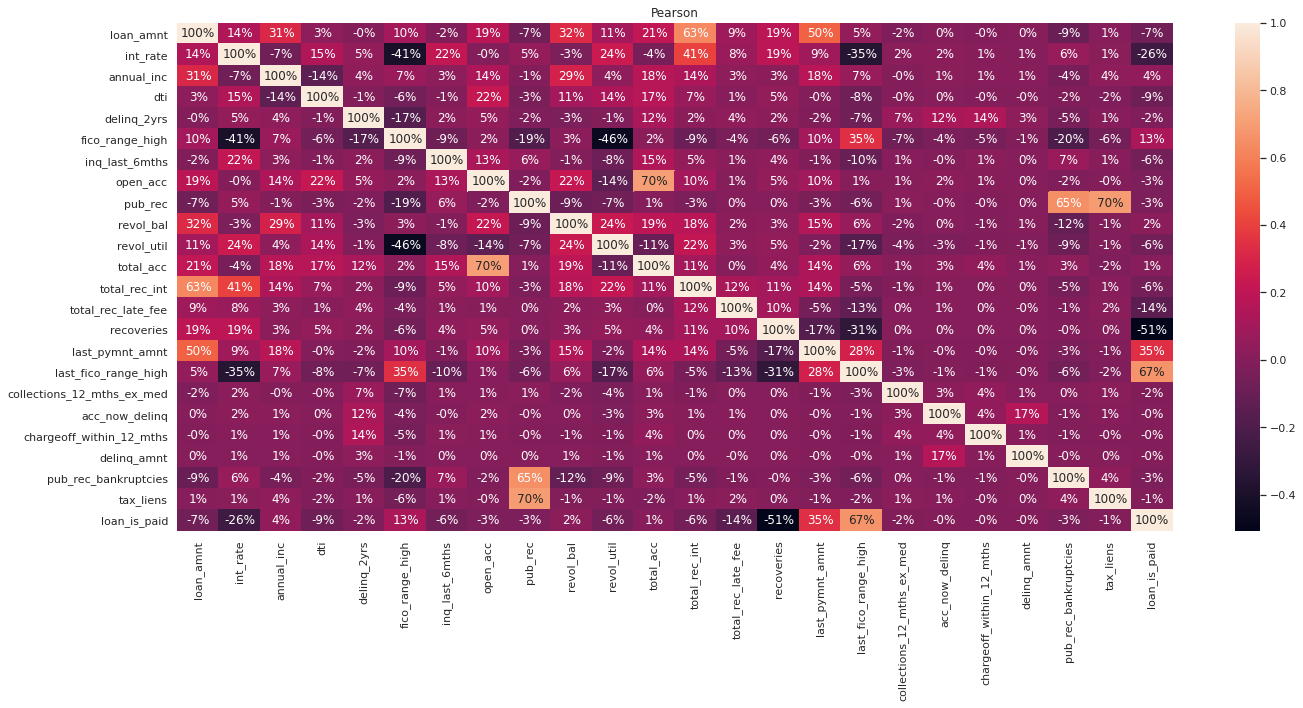

In [36]:
f, (ax1) = plt.subplots(1, figsize=(20, 10))
ax1.set_title("Pearson")
sns.heatmap(corr_mat, ax=ax1 , yticklabels=corrnumeric, xticklabels=corrnumeric, annot=True, fmt='.0%')
plt.yticks(rotation=0) 
plt.xticks(rotation=90)
ax1.figure.tight_layout()
plt.show();

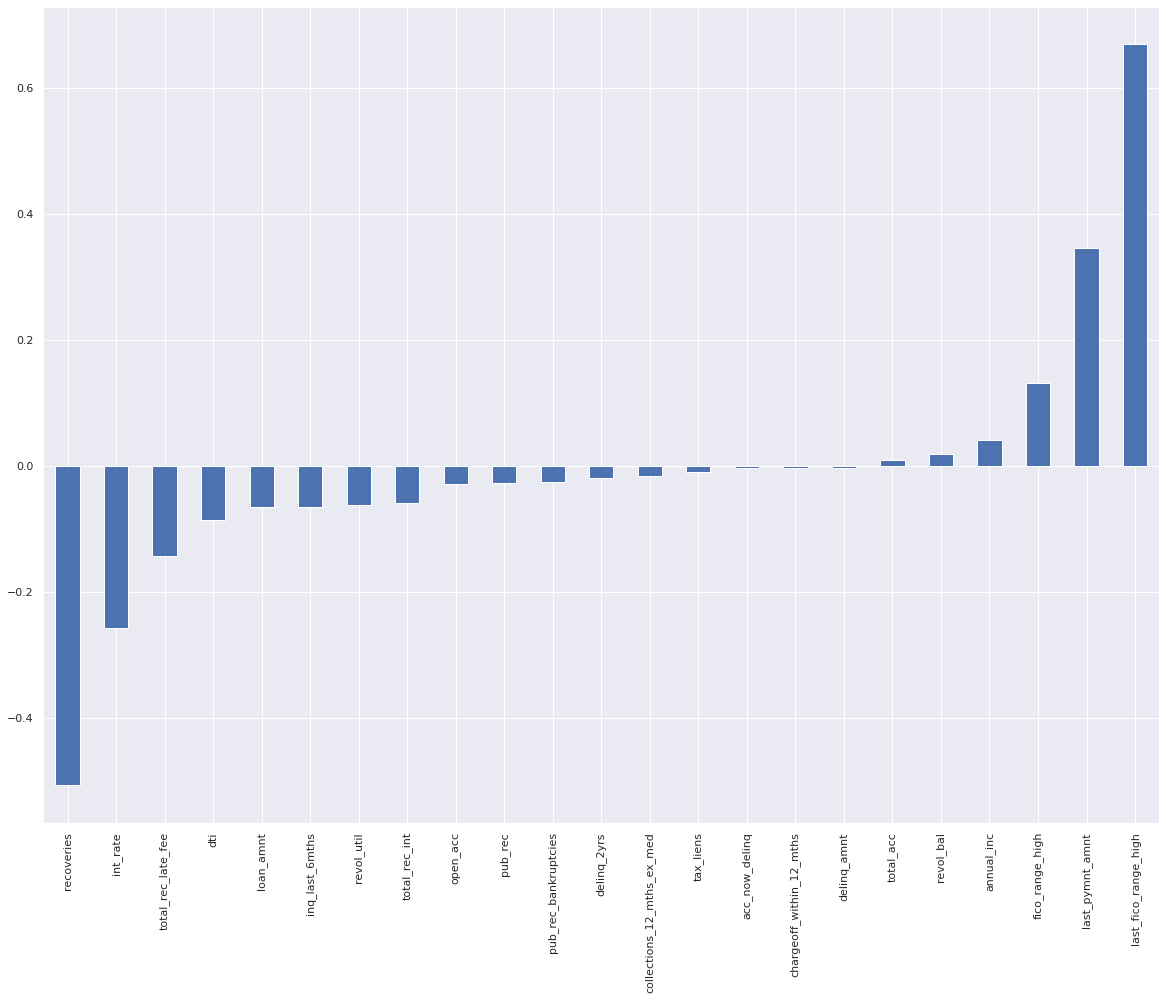

In [40]:
plt.figure(figsize=(20,15))
corr_mat.iloc[:-1,-1].sort_values().plot.bar(rot=90); # -1, -1 for the last column added loan_is_paid

### term Column

In [43]:
distinct_terms = [x.term for x in df.select('term').distinct().collect()]

In [44]:
distinct_terms

[' 36 months', ' 60 months']

In [45]:
mapping = dict(zip(distinct_terms, [36, 60]))
mapping_expr = create_map([lit(x) for x in chain(*mapping.items())])
df = df.withColumn("term_months", mapping_expr[col("term")])

In [46]:
df.select("term_months").distinct().show()

+-----------+
|term_months|
+-----------+
|         60|
|         36|
+-----------+



In [47]:
df = df.drop("term")

In [48]:
corrcategorical, _ = get_cat_numeric_cols(df)
print(corrcategorical)

['grade', 'sub_grade', 'home_ownership', 'verification_status', 'issue_d', 'url', 'purpose', 'zip_code', 'addr_state', 'earliest_cr_line', 'initial_list_status', 'last_pymnt_d', 'last_credit_pull_d', 'application_type', 'disbursement_method', 'debt_settlement_flag']


### home_ownership Column

In [49]:
df.groupBy('home_ownership').count().show()

+--------------+------+
|home_ownership| count|
+--------------+------+
|           OWN|144179|
|          RENT|532381|
|      MORTGAGE|663782|
|           ANY|   283|
|         OTHER|   142|
|          NONE|    45|
+--------------+------+



> We can merge NONE with ANY in one category

In [50]:
df = df.replace("NONE", "ANY", "home_ownership")

In [51]:
df.groupBy("home_ownership").count().show()

+--------------+------+
|home_ownership| count|
+--------------+------+
|           OWN|144179|
|          RENT|532381|
|      MORTGAGE|663782|
|           ANY|   328|
|         OTHER|   142|
+--------------+------+



### grade And sub_grade Columns

In [54]:
l = ["grade", "sub_grade", "loan_is_paid"]
features_dict = {}
for f in l:
    features_dict[f] = []
for val in df.select(*l).collect():
    for f, l in features_dict.items():
        l.append(val[f])

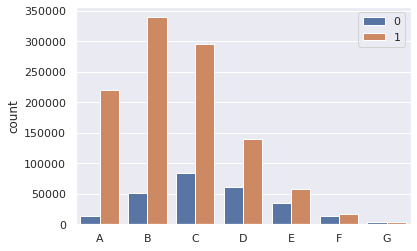

In [64]:
l = list(set(features_dict["grade"]))
l.sort()
sns.countplot(x=features_dict["grade"], order=l, hue=features_dict["loan_is_paid"]);

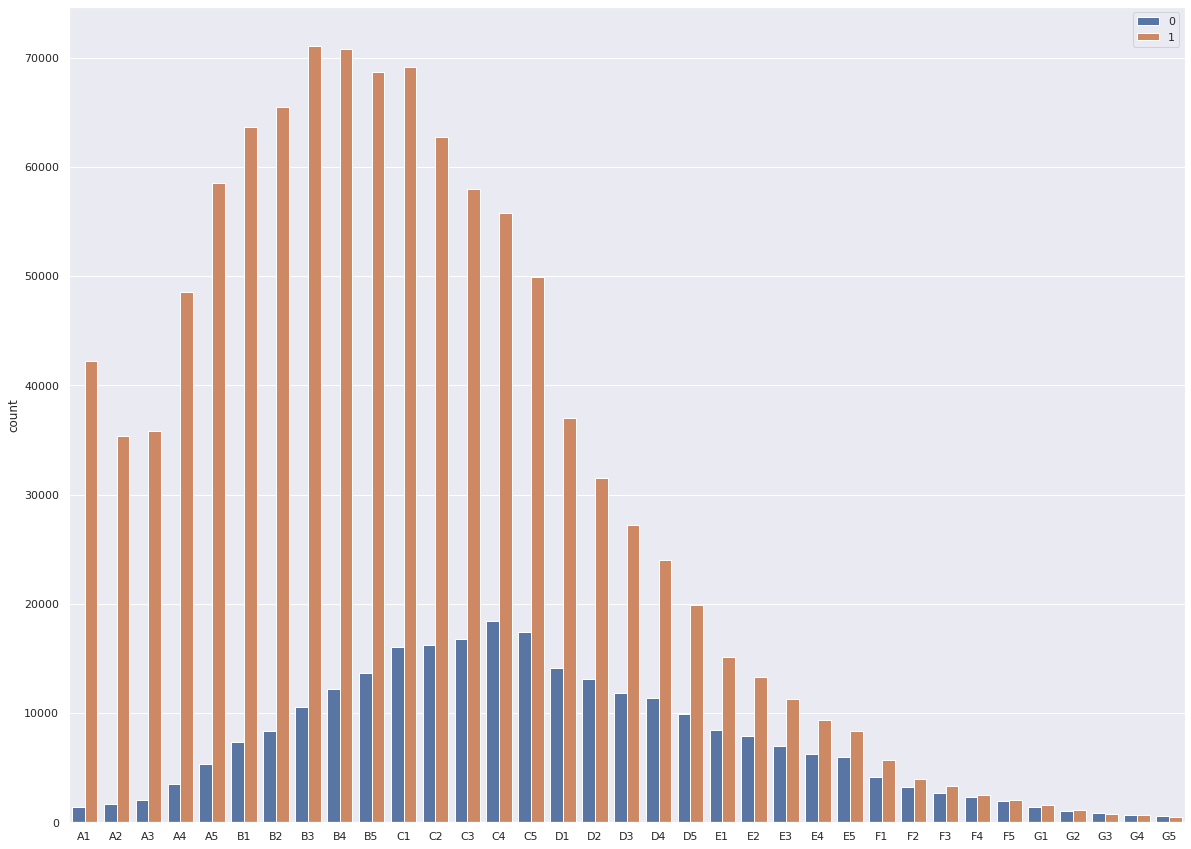

In [60]:
l = list(set(features_dict["sub_grade"]))
l.sort()
plt.figure(figsize=(20,15))
sns.countplot(x=features_dict["sub_grade"], order=l, hue=features_dict["loan_is_paid"]);

> grade is part of sub_grade, so let's drop it

> Date columns: issue_d, last_pymnt_d, last_credit_pull_d are not important to the analysis

> earliest_cr_line which is the month when reported credit line was opened is not important to the analysis

> url for LC page with listing data is not important to the analysis

> addresses: zip_code, addr_state are not important to the analysis

In [61]:
to_drop=["grade", "issue_d", "last_pymnt_d", "last_credit_pull_d",
         "earliest_cr_line", "url", "zip_code", "addr_state"]
df = df.drop(*to_drop)

In [62]:
df.printSchema()

root
 |-- loan_amnt: double (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: double (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- dti: double (nullable = true)
 |-- delinq_2yrs: double (nullable = true)
 |-- fico_range_high: double (nullable = true)
 |-- inq_last_6mths: double (nullable = true)
 |-- open_acc: double (nullable = true)
 |-- pub_rec: double (nullable = true)
 |-- revol_bal: double (nullable = true)
 |-- revol_util: double (nullable = true)
 |-- total_acc: double (nullable = true)
 |-- initial_list_status: string (nullable = true)
 |-- total_rec_int: double (nullable = true)
 |-- total_rec_late_fee: double (nullable = true)
 |-- recoveries: double (nullable = true)
 |-- last_pymnt_amnt: double (nullable = true)
 |-- last_fico_range_high: double (nullable = true)
 |-- collections_12_mths_ex_med: d

In [46]:
df.limit(5).toPandas()

,loan_amnt,int_rate,sub_grade,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,fico_range_high,...,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,disbursement_method,debt_settlement_flag,loan_is_paid,term_months
0,3600.0,13.99,C4,MORTGAGE,55000.0,Not Verified,debt_consolidation,5.910000,0.0,679.0,...,Individual,0.0,0.0,0.0,0.0,0.0,Cash,N,1,36
1,24700.0,11.99,C1,MORTGAGE,65000.0,Not Verified,small_business,16.059999,1.0,719.0,...,Individual,0.0,0.0,0.0,0.0,0.0,Cash,N,1,36
2,20000.0,10.78,B4,MORTGAGE,63000.0,Not Verified,home_improvement,10.780000,0.0,699.0,...,Joint App,0.0,0.0,0.0,0.0,0.0,Cash,N,1,60
3,10400.0,22.45,F1,MORTGAGE,104433.0,Source Verified,major_purchase,25.370001,1.0,699.0,...,Individual,0.0,0.0,0.0,0.0,0.0,Cash,N,1,60
4,11950.0,13.44,C3,RENT,34000.0,Source Verified,debt_consolidation,10.200000,0.0,694.0,...,Individual,0.0,0.0,0.0,0.0,0.0,Cash,N,1,36


## Handle Categorical Features

In [47]:
# Spark Pipeline
cat_features, _ = get_cat_numeric_cols(df)
assembler_inputs = list(set(df.columns) - set(cat_features)) + [feature + "_class_vec" for feature in cat_features]
assembler_inputs.remove('loan_is_paid')
assembler_inputs

['tax_liens',
 'dti',
 'fico_range_high',
 'pub_rec',
 'total_rec_int',
 'loan_amnt',
 'total_acc',
 'collections_12_mths_ex_med',
 'last_pymnt_amnt',
 'acc_now_delinq',
 'recoveries',
 'term_months',
 'delinq_amnt',
 'chargeoff_within_12_mths',
 'open_acc',
 'pub_rec_bankruptcies',
 'last_fico_range_high',
 'delinq_2yrs',
 'total_rec_late_fee',
 'int_rate',
 'revol_util',
 'inq_last_6mths',
 'revol_bal',
 'annual_inc',
 'sub_grade_class_vec',
 'verification_status_class_vec',
 'application_type_class_vec',
 'initial_list_status_class_vec',
 'purpose_class_vec',
 'home_ownership_class_vec',
 'disbursement_method_class_vec',
 'debt_settlement_flag_class_vec']

In [48]:
# Pipeline Stages List
stages = []

# Loop for StringIndexer and OHE for Categorical Variables
for features in cat_features:
    # Index Categorical Features
    string_indexer = StringIndexer(inputCol=features, outputCol=features + "_index")
    # One Hot Encode Categorical Features
    encoder = OneHotEncoder(inputCols=[string_indexer.getOutputCol()], outputCols=[features + "_class_vec"])
    # Append Pipeline Stages
    stages += [string_indexer, encoder]
    
assembler_final = VectorAssembler(inputCols=assembler_inputs, outputCol="features") 

scalar = MinMaxScaler(inputCol='features', outputCol='scaled_features')

stages += [assembler_final, scalar]

In [49]:
stages

[StringIndexer_75866dd8040f,
 OneHotEncoder_e5610f249866,
 StringIndexer_dc0bbb79cd1d,
 OneHotEncoder_86c8d7239e83,
 StringIndexer_9179443c1993,
 OneHotEncoder_d7bf4e8777b6,
 StringIndexer_9e67d2a01b6b,
 OneHotEncoder_0d3864efd853,
 StringIndexer_ff38be680a86,
 OneHotEncoder_9a8bcd985ee0,
 StringIndexer_9a18d6e28072,
 OneHotEncoder_3f76e5f2dddd,
 StringIndexer_8c35f3fb3bbb,
 OneHotEncoder_f35cc6eccc9f,
 StringIndexer_7b8983afb5ba,
 OneHotEncoder_1ad18e044733,
 VectorAssembler_262c906d8fd2,
 MinMaxScaler_97f94fe9bb18]

In [50]:
# Set Pipeline
pipeline = Pipeline(stages=stages)

In [51]:
# Fit Pipeline to Data
pipeline_model = pipeline.fit(df)

In [52]:
# Transform Data using Fitted Pipeline
trans_df = pipeline_model.transform(df)

In [53]:
# Preview Newly Transformed Data
trans_df.limit(5).toPandas()

,loan_amnt,int_rate,sub_grade,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,fico_range_high,...,purpose_index,purpose_class_vec,home_ownership_index,home_ownership_class_vec,disbursement_method_index,disbursement_method_class_vec,debt_settlement_flag_index,debt_settlement_flag_class_vec,features,scaled_features
0,3600.0,13.99,C4,MORTGAGE,55000.0,Not Verified,debt_consolidation,5.910000,0.0,679.0,...,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"(1.0, 0.0, 0.0, 0.0)",0.0,(1.0),0.0,(1.0),"(0.0, 5.909999847412109, 679.0, 0.0, 821.71997...","(0.0, 0.006909999847412109, 0.0806451612903225..."
1,24700.0,11.99,C1,MORTGAGE,65000.0,Not Verified,small_business,16.059999,1.0,719.0,...,6.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",0.0,"(1.0, 0.0, 0.0, 0.0)",0.0,(1.0),0.0,(1.0),"(0.0, 16.059999465942383, 719.0, 0.0, 979.6599...","(0.0, 0.017059999465942385, 0.2956989247311828..."
2,20000.0,10.78,B4,MORTGAGE,63000.0,Not Verified,home_improvement,10.780000,0.0,699.0,...,2.0,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"(1.0, 0.0, 0.0, 0.0)",0.0,(1.0),0.0,(1.0),"(0.0, 10.779999732971191, 699.0, 0.0, 2705.919...","(0.0, 0.011779999732971192, 0.1881720430107527..."
3,10400.0,22.45,F1,MORTGAGE,104433.0,Source Verified,major_purchase,25.370001,1.0,699.0,...,4.0,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"(1.0, 0.0, 0.0, 0.0)",0.0,(1.0),0.0,(1.0),"(0.0, 25.3700008392334, 699.0, 0.0, 1340.5, 10...","(0.0, 0.0263700008392334, 0.18817204301075272,..."
4,11950.0,13.44,C3,RENT,34000.0,Source Verified,debt_consolidation,10.200000,0.0,694.0,...,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,"(0.0, 1.0, 0.0, 0.0)",0.0,(1.0),0.0,(1.0),"(0.0, 10.199999809265137, 694.0, 0.0, 1758.949...","(0.0, 0.011199999809265136, 0.1612903225806451..."


In [54]:
trans_df.printSchema()

root
 |-- loan_amnt: double (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: float (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- dti: float (nullable = true)
 |-- delinq_2yrs: float (nullable = true)
 |-- fico_range_high: float (nullable = true)
 |-- inq_last_6mths: float (nullable = true)
 |-- open_acc: float (nullable = true)
 |-- pub_rec: float (nullable = true)
 |-- revol_bal: float (nullable = true)
 |-- revol_util: float (nullable = true)
 |-- total_acc: float (nullable = true)
 |-- initial_list_status: string (nullable = true)
 |-- total_rec_int: float (nullable = true)
 |-- total_rec_late_fee: float (nullable = true)
 |-- recoveries: float (nullable = true)
 |-- last_pymnt_amnt: float (nullable = true)
 |-- last_fico_range_high: float (nullable = true)
 |-- collections_12_mths_ex_med: float (nullable 

In [55]:
# cols = list(set(df.columns) - {'features'})
dl_df = trans_df.select('scaled_features', 'loan_is_paid')

In [56]:
dl_df.printSchema()

root
 |-- scaled_features: vector (nullable = true)
 |-- loan_is_paid: integer (nullable = true)



In [57]:
dl_df.show(1)

+--------------------+------------+
|     scaled_features|loan_is_paid|
+--------------------+------------+
|(81,[1,2,4,5,6,8,...|           1|
+--------------------+------------+
only showing top 1 row



<a id="7"></a>
# Deeplearning Model

In [58]:
# Number of Inputs or Input Dimensions
input_dim = 81

In [67]:
def create_model():
    # Set up Deep Learning Model / Architecture
    model = Sequential()
    model.add(Dense(units=78, input_shape=(input_dim,), activation='relu'))
    model.add(Dense(units=39,activation='relu'))
    model.add(Dense(units=19,activation='relu'))
    model.add(Dense(units=8,activation='relu'))
    model.add(Dense(units=4,activation='relu'))
    model.add(Dense(units=1,activation='sigmoid'))
    return model

def compile_model(model):
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [68]:
model = create_model()
model = compile_model(model)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 78)                6396      
_________________________________________________________________
dense_7 (Dense)              (None, 39)                3081      
_________________________________________________________________
dense_8 (Dense)              (None, 19)                760       
_________________________________________________________________
dense_9 (Dense)              (None, 8)                 160       
_________________________________________________________________
dense_10 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 5         
Total params: 10,438
Trainable params: 10,438
Non-trainable params: 0
__________________________________________________

In [61]:
dl_df = dl_df.toPandas()

In [62]:
series = dl_df['scaled_features'].apply(lambda x : np.array(x.toArray())).to_numpy().reshape(-1,1)

In [63]:
dl_x = np.apply_along_axis(lambda x : x[0], 1, series)

In [64]:
dl_y = dl_df.loan_is_paid.values

In [65]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(dl_x, dl_y, test_size=0.2, random_state=42)

In [69]:
model.fit(x=x_train, y=y_train, epochs=40, batch_size=512, validation_data=(x_test, y_test), verbose=1)

Epoch 1/40
2096/2096 [==============================] - 33s 10ms/step - loss: 0.5434 - accuracy: 0.8413 - val_loss: 0.1932 - val_accuracy: 0.9663
Epoch 2/40
2096/2096 [==============================] - 23s 11ms/step - loss: 0.1654 - accuracy: 0.9668 - val_loss: 0.1250 - val_accuracy: 0.9628
Epoch 3/40
2096/2096 [==============================] - 25s 12ms/step - loss: 0.1009 - accuracy: 0.9713 - val_loss: 0.0843 - val_accuracy: 0.9722
Epoch 4/40
2096/2096 [==============================] - 27s 13ms/step - loss: 0.0783 - accuracy: 0.9740 - val_loss: 0.0769 - val_accuracy: 0.9717
Epoch 5/40
2096/2096 [==============================] - 28s 13ms/step - loss: 0.0690 - accuracy: 0.9757 - val_loss: 0.0650 - val_accuracy: 0.9766
Epoch 6/40
2096/2096 [==============================] - 29s 14ms/step - loss: 0.0650 - accuracy: 0.9765 - val_loss: 0.0688 - val_accuracy: 0.9737
Epoch 7/40
2096/2096 [==============================] - 31s 15ms/step - loss: 0.0623 - accuracy: 0.9772 - val_loss: 0.0607 -

In [70]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot:>

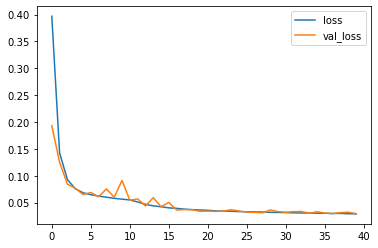

In [71]:
losses[['loss','val_loss']].plot()

<AxesSubplot:>

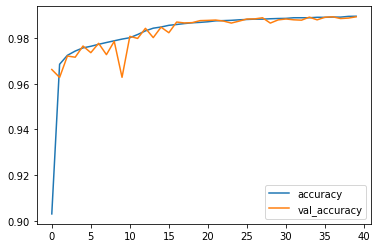

In [72]:
losses[['accuracy','val_accuracy']].plot()

In [73]:
model.save('loan_prediction_model')

INFO:tensorflow:Assets written to: loan_prediction_model/assets


<a id="8"></a>
# Gradient Boosting Tree (spark)

In [76]:
spark_df = trans_df.select('scaled_features', 'loan_is_paid')

In [77]:
spark_train, spark_test = spark_df.randomSplit([.8, .2], seed=42)

In [78]:
from pyspark.ml.classification import GBTClassifier
gb = GBTClassifier(labelCol = 'loan_is_paid', featuresCol = 'scaled_features')

In [79]:
gbModel = gb.fit(spark_train)

In [80]:
gb_predictions = gbModel.transform(spark_test)

In [81]:
gbModel.save('gbtc_loan_prediction')

In [83]:
gb_predictions.select('scaled_features', 'loan_is_paid', 'prediction', 'probability').show(10)

+--------------------+------------+----------+--------------------+
|     scaled_features|loan_is_paid|prediction|         probability|
+--------------------+------------+----------+--------------------+
|(81,[0,1,2,3,4,5,...|           1|       1.0|[0.05270399993585...|
|(81,[0,1,2,3,4,5,...|           1|       1.0|[0.05443185145658...|
|(81,[0,1,2,3,4,5,...|           0|       0.0|[0.95635347857271...|
|(81,[0,1,2,3,4,5,...|           0|       0.0|[0.95635347857271...|
|(81,[0,1,2,3,4,5,...|           0|       0.0|[0.95635347857271...|
|(81,[0,1,2,3,4,5,...|           0|       0.0|[0.95635347857271...|
|(81,[0,1,2,3,4,5,...|           0|       0.0|[0.95635347857271...|
|(81,[0,1,2,3,4,5,...|           1|       1.0|[0.04368680010337...|
|(81,[0,1,2,3,4,5,...|           1|       1.0|[0.08128007245037...|
|(81,[0,1,2,3,4,5,...|           0|       1.0|[0.27032648846438...|
+--------------------+------------+----------+--------------------+
only showing top 10 rows



In [98]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="loan_is_paid", metricName="areaUnderROC")

print("Test Area Under ROC: " + str(evaluator.evaluate(gb_predictions)))

Test Area Under ROC: 0.9524807005159022


In [99]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="loan_is_paid", metricName="f1")
print("Test f1 score: ", evaluator.evaluate(gb_predictions))

Test f1 score:  0.9744686686161473


In [100]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="loan_is_paid", metricName="accuracy")
print("Test accuracy: ", evaluator.evaluate(gb_predictions))

Test accuracy:  0.9746691093995363


In [101]:
gb_predictions.select("loan_is_paid", "prediction").groupBy("loan_is_paid", "prediction").count().show()

+------------+----------+------+
|loan_is_paid|prediction| count|
+------------+----------+------+
|           1|       0.0|  2304|
|           0|       0.0| 48570|
|           1|       1.0|212115|
|           0|       1.0|  4471|
+------------+----------+------+

